# 08-06 Text Generation using RNN  (RNN을 이용한 텍스트 생성)


출처:https://wikidocs.net/45101


## 1. 1. RNN을 이용하여 텍스트 생성하기


'경마장에 있는 말이 뛰고 있다' 
'그의 말이 법이다'
'가는 말이 고와야 오는 말이 곱다'라는 세 가지 문장

모델이 문맥을 학습할 수 있도록 전체 문장의 앞의 단어들을 전부 고려하여 학습하도록 데이터를 재구성한다면 아래와 같이 총 11개의 샘플이 구성됩니다.

In [1]:
from IPython.display import Image

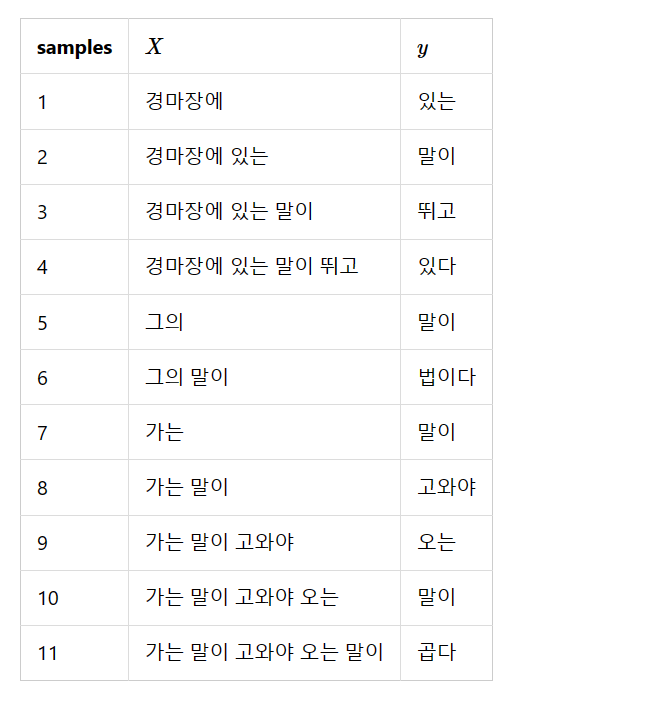

In [2]:
Image("image/08-06-01 Text Generation using RNN.png")

## 1) 데이터에 대한 이해와 전처리

In [3]:
# 1) 데이터에 대한 이해와 전처리

import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [4]:
text = """경마장에 있는 말이 뛰고 있다\n
그의 말이 법이다\n
가는 말이 고와야 오는 말이 곱다\n"""

# 우선 예제로 언급한 3개의 한국어 문장을 저장합니다.



In [5]:
# 단어 집합을 생성하고 크기를 확인해보겠습니다. 
# 단어 집합의 크기를 저장할 때는 케라스 토크나이저의 정수 
# 인코딩은 인덱스가 1부터 시작하지만, 패딩을 위한 0을 고려하여 +1을 해줍니다.

tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])
vocab_size = len(tokenizer.word_index) + 1
print('단어 집합의 크기 : %d' % vocab_size)

단어 집합의 크기 : 12


In [6]:
# 각 단어와 단어에 부여된 정수 인덱스를 출력해보겠습니다.


print(tokenizer.word_index)


{'말이': 1, '경마장에': 2, '있는': 3, '뛰고': 4, '있다': 5, '그의': 6, '법이다': 7, '가는': 8, '고와야': 9, '오는': 10, '곱다': 11}


In [7]:
# 훈련 데이터를 만들어보겠습니다.

sequences = list()
for line in text.split('\n'): # 줄바꿈 문자를 기준으로 문장 토큰화
    encoded = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(encoded)):
        sequence = encoded[:i+1]
        sequences.append(sequence)

print('학습에 사용할 샘플의 개수: %d' % len(sequences))

학습에 사용할 샘플의 개수: 11


In [8]:
print(sequences)

# 위의 데이터는 아직 레이블로 사용될 단어를 분리하지 않은 훈련 데이터입니다. 
# [2, 3]은 [경마장에, 있는]에 해당되며 [2, 3, 1]은 [경마장에, 있는, 말이]에 해당됩니다. 
# 전체 훈련 데이터에 대해서 맨 우측에 있는 단어에 대해서만 레이블로 분리해야 합니다.

# 현재 육안으로 봤을 때, 길이가 가장 긴 샘플은 [8, 1, 9, 10, 1, 11]이고 길이는 6입니다.
# 이를 코드로는 다음과 같이 구할 수 있습니다.

[[2, 3], [2, 3, 1], [2, 3, 1, 4], [2, 3, 1, 4, 5], [6, 1], [6, 1, 7], [8, 1], [8, 1, 9], [8, 1, 9, 10], [8, 1, 9, 10, 1], [8, 1, 9, 10, 1, 11]]


In [9]:
max_len = max(len(l) for l in sequences) # 모든 샘플에서 길이가 가장 긴 샘플의 길이 출력
print('샘플의 최대 길이 : {}'.format(max_len))

샘플의 최대 길이 : 6


In [10]:
# 전체 훈련 데이터에서 가장 긴 샘플의 길이가 6임을 확인하였습니다. 
# 전체 샘플의 길이를 6으로 패딩합니다.

sequences = pad_sequences(sequences, maxlen=max_len, padding='pre')

# pad_sequences()는 모든 샘플에 대해서 0을 사용하여 길이를 맞춰줍니다. 
# maxlen의 값으로 6을 주면 모든 샘플의 길이를 6으로 맞춰주며, padding의 인자로 'pre'를 주면 길이가 6보다 짧은 샘플의 앞에 0으로 채웁니다.
# 전체 훈련 데이터를 출력해봅니다.

In [11]:
print(sequences)


[[ 0  0  0  0  2  3]
 [ 0  0  0  2  3  1]
 [ 0  0  2  3  1  4]
 [ 0  2  3  1  4  5]
 [ 0  0  0  0  6  1]
 [ 0  0  0  6  1  7]
 [ 0  0  0  0  8  1]
 [ 0  0  0  8  1  9]
 [ 0  0  8  1  9 10]
 [ 0  8  1  9 10  1]
 [ 8  1  9 10  1 11]]


In [12]:
# 길이가 6보다 짧은 모든 샘플에 대해서 앞에 0을 채워서 모든 샘플의 길이를 6으로 바꿨습니다. 
# 이제 각 샘플의 마지막 단어를 레이블로 분리합시다. 레이블의 분리는 Numpy를 이용해서 가능합니다. 
# 리스트의 마지막 값을 제외하고 저장한 것은 X, 
# 리스트의 마지막 값만 저장한 것은 y. 이는 레이블에 해당됩니다.

sequences = np.array(sequences)
X = sequences[:,:-1]
y = sequences[:,-1]

In [13]:
print(X)


[[ 0  0  0  0  2]
 [ 0  0  0  2  3]
 [ 0  0  2  3  1]
 [ 0  2  3  1  4]
 [ 0  0  0  0  6]
 [ 0  0  0  6  1]
 [ 0  0  0  0  8]
 [ 0  0  0  8  1]
 [ 0  0  8  1  9]
 [ 0  8  1  9 10]
 [ 8  1  9 10  1]]


In [14]:
print(y)

# 레이블이 분리되었습니다. 
# RNN 모델에 훈련 데이터를 훈련 시키기 전에 레이블에 대해서 원-핫 인코딩을 수행합니다.

[ 3  1  4  5  1  7  1  9 10  1 11]


In [15]:
y = to_categorical(y, num_classes=vocab_size)


In [16]:
print(y)

# 정상적으로 원-핫 인코딩이 수행된 것을 볼 수 있습니다.

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


# 2) 모델 설계하기

RNN 모델에 데이터를 훈련시킵니다.

하이퍼파라미터인 임베딩 벡터의 차원은 10, 은닉 상태의 크기는 32

 다 대 일 구조의 RNN을 사용
 
 전결합층(Fully Connected Layer)을 출력층으로 단어 집합 크기만큼의 뉴런을 배치하여 모델을 설계
 
  다중 클래스 분류 문제를 수행하는 모델
  
  다중 클래스 분류 문제의 경우, 출력층에 소프트맥스 회귀를 사용해야 하므로 활성화 함수로는 소프트맥스 함수를 사용하고, 손실 함수로 크로스 엔트로피 함수를 사용하여 200 에포크를 수행
  

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN

In [18]:
embedding_dim = 10
hidden_units = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(SimpleRNN(hidden_units))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=200, verbose=2)

Epoch 1/200
1/1 - 1s - loss: 2.4386 - accuracy: 0.3636 - 826ms/epoch - 826ms/step
Epoch 2/200
1/1 - 0s - loss: 2.4252 - accuracy: 0.3636 - 6ms/epoch - 6ms/step
Epoch 3/200
1/1 - 0s - loss: 2.4114 - accuracy: 0.3636 - 0s/epoch - 0s/step
Epoch 4/200
1/1 - 0s - loss: 2.3974 - accuracy: 0.3636 - 9ms/epoch - 9ms/step
Epoch 5/200
1/1 - 0s - loss: 2.3829 - accuracy: 0.3636 - 0s/epoch - 0s/step
Epoch 6/200
1/1 - 0s - loss: 2.3679 - accuracy: 0.3636 - 0s/epoch - 0s/step
Epoch 7/200
1/1 - 0s - loss: 2.3523 - accuracy: 0.4545 - 13ms/epoch - 13ms/step
Epoch 8/200
1/1 - 0s - loss: 2.3362 - accuracy: 0.4545 - 0s/epoch - 0s/step
Epoch 9/200
1/1 - 0s - loss: 2.3194 - accuracy: 0.4545 - 0s/epoch - 0s/step
Epoch 10/200
1/1 - 0s - loss: 2.3019 - accuracy: 0.4545 - 14ms/epoch - 14ms/step
Epoch 11/200
1/1 - 0s - loss: 2.2836 - accuracy: 0.4545 - 877us/epoch - 877us/step
Epoch 12/200
1/1 - 0s - loss: 2.2645 - accuracy: 0.4545 - 0s/epoch - 0s/step
Epoch 13/200
1/1 - 0s - loss: 2.2446 - accuracy: 0.4545 - 0s/

Epoch 105/200
1/1 - 0s - loss: 0.5214 - accuracy: 0.9091 - 3ms/epoch - 3ms/step
Epoch 106/200
1/1 - 0s - loss: 0.5102 - accuracy: 0.9091 - 3ms/epoch - 3ms/step
Epoch 107/200
1/1 - 0s - loss: 0.4992 - accuracy: 0.9091 - 3ms/epoch - 3ms/step
Epoch 108/200
1/1 - 0s - loss: 0.4884 - accuracy: 0.9091 - 3ms/epoch - 3ms/step
Epoch 109/200
1/1 - 0s - loss: 0.4779 - accuracy: 0.9091 - 3ms/epoch - 3ms/step
Epoch 110/200
1/1 - 0s - loss: 0.4676 - accuracy: 0.9091 - 3ms/epoch - 3ms/step
Epoch 111/200
1/1 - 0s - loss: 0.4576 - accuracy: 0.9091 - 2ms/epoch - 2ms/step
Epoch 112/200
1/1 - 0s - loss: 0.4478 - accuracy: 0.9091 - 2ms/epoch - 2ms/step
Epoch 113/200
1/1 - 0s - loss: 0.4382 - accuracy: 0.9091 - 4ms/epoch - 4ms/step
Epoch 114/200
1/1 - 0s - loss: 0.4289 - accuracy: 0.9091 - 2ms/epoch - 2ms/step
Epoch 115/200
1/1 - 0s - loss: 0.4197 - accuracy: 0.9091 - 3ms/epoch - 3ms/step
Epoch 116/200
1/1 - 0s - loss: 0.4108 - accuracy: 0.9091 - 4ms/epoch - 4ms/step
Epoch 117/200
1/1 - 0s - loss: 0.4021 - 

In [19]:
# 모델이 정확하게 예측하고 있는지 문장을 생성하는 함수를 만들어서 출력해봅시다.

def sentence_generation(model, tokenizer, current_word, n): # 모델, 토크나이저, 현재 단어, 반복할 횟수
    init_word = current_word
    sentence = ''

    # n번 반복
    for _ in range(n):
        # 현재 단어에 대한 정수 인코딩과 패딩
        encoded = tokenizer.texts_to_sequences([current_word])[0]
        encoded = pad_sequences([encoded], maxlen=5, padding='pre')
        # 입력한 X(현재 단어)에 대해서 Y를 예측하고 Y(예측한 단어)를 result에 저장.
        result = model.predict(encoded, verbose=0)
        result = np.argmax(result, axis=1)

        for word, index in tokenizer.word_index.items(): 
            # 만약 예측한 단어와 인덱스와 동일한 단어가 있다면 break
            if index == result:
                break

        # 현재 단어 + ' ' + 예측 단어를 현재 단어로 변경
        current_word = current_word + ' '  + word

        # 예측 단어를 문장에 저장
        sentence = sentence + ' ' + word

    sentence = init_word + sentence
    return sentence

In [20]:
# 입력된 단어로부터 다음 단어를 예측해서 문장을 생성하는 함수를 만들었습니다. 
# '경마장에' 라는 단어 뒤에는 총 4개의 단어가 있으므로 4번 예측해봅시다.

print(sentence_generation(model, tokenizer, '경마장에', 4))


경마장에 있는 말이 뛰고 있다


In [21]:
print(sentence_generation(model, tokenizer, '그의', 2))


그의 말이 법이다


In [22]:
print(sentence_generation(model, tokenizer, '가는', 5))


가는 말이 고와야 오는 말이 곱다


충분한 훈련 데이터를 갖고 있지 못하므로 위에서 문장의 길이에 맞게 적절하게 예측해야하는 횟수 4, 2, 5를 각각 인자값으로 주었습니다.

이 이상의 숫자를 주면 기계는 '있다', '법이다', '곱다' 다음에 나오는 단어가 무엇인지 배운 적이 없으므로 임의 예측

# 2. LSTM을 이용하여 텍스트 생성하기


이번에는 LSTM을 통해 보다 많은 데이터로 텍스트를 생성해보겠습니다. 본질적으로 앞에서 한 것과 동일한 실습입니다.

## 1) 데이터에 대한 이해와 전처리

사용할 데이터는 뉴욕 타임즈 기사의 제목입니다. 아래의 링크에서 ArticlesApril2018.csv 데이터를 다운로드 합니다.



In [23]:
import pandas as pd
import numpy as np
from string import punctuation

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [25]:
# 다운로드한 훈련 데이터를 데이터프레임에 저장합니다.

df = pd.read_csv('ArticlesApril2018.csv')
df.head()

,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,5adf6684068401528a2aa69b,781,By JOHN BRANCH,article,Former N.F.L. Cheerleaders’ Settlement Offer: ...,"['Workplace Hazards and Violations', 'Football...",68,Sports,0,2018-04-24 17:16:49,Pro Football,"“I understand that they could meet with us, pa...",The New York Times,News,https://www.nytimes.com/2018/04/24/sports/foot...
1,5adf653f068401528a2aa697,656,By LISA FRIEDMAN,article,E.P.A. to Unveil a New Rule. Its Effect: Less ...,"['Environmental Protection Agency', 'Pruitt, S...",68,Climate,0,2018-04-24 17:11:21,Unknown,The agency plans to publish a new regulation T...,The New York Times,News,https://www.nytimes.com/2018/04/24/climate/epa...
2,5adf4626068401528a2aa628,2427,By PETE WELLS,article,"The New Noma, Explained","['Restaurants', 'Noma (Copenhagen, Restaurant)...",66,Dining,0,2018-04-24 14:58:44,Unknown,What’s it like to eat at the second incarnatio...,The New York Times,News,https://www.nytimes.com/2018/04/24/dining/noma...
3,5adf40d2068401528a2aa619,626,By JULIE HIRSCHFELD DAVIS and PETER BAKER,article,Unknown,"['Macron, Emmanuel (1977- )', 'Trump, Donald J...",68,Washington,0,2018-04-24 14:35:57,Europe,President Trump welcomed President Emmanuel Ma...,The New York Times,News,https://www.nytimes.com/2018/04/24/world/europ...
4,5adf3d64068401528a2aa60f,815,By IAN AUSTEN and DAN BILEFSKY,article,Unknown,"['Toronto, Ontario, Attack (April, 2018)', 'Mu...",68,Foreign,0,2018-04-24 14:21:21,Canada,"Alek Minassian, 25, a resident of Toronto’s Ri...",The New York Times,News,https://www.nytimes.com/2018/04/24/world/canad...


In [26]:
print('열의 개수: ',len(df.columns))
print(df.columns)

열의 개수:  15
Index(['articleID', 'articleWordCount', 'byline', 'documentType', 'headline',
       'keywords', 'multimedia', 'newDesk', 'printPage', 'pubDate',
       'sectionName', 'snippet', 'source', 'typeOfMaterial', 'webURL'],
      dtype='object')


In [27]:
# 총 15개의 열이 존재합니다. 
# 여기서 사용할 열은 제목에 해당되는 headline 열입니다. Null 값이 있는지 확인해봅시다.

print(df['headline'].isnull().values.any())

# Null 값은 별도로 없는 것으로 보입니다. 
# headline 열에서 모든 신문 기사의 제목을 뽑아서 하나의 리스트로 저장해보도록 하겠습니다.

False


In [28]:
headline = []
# 헤드라인의 값들을 리스트로 저장
headline.extend(list(df.headline.values)) 
headline[:5]

# headline이라는 리스트에 모든 신문 기사의 제목을 저장했습니다. 
# 저장한 리스트에서 상위 5개만 출력해보았습니다.

['Former N.F.L. Cheerleaders’ Settlement Offer: $1 and a Meeting With Goodell',
 'E.P.A. to Unveil a New Rule. Its Effect: Less Science in Policymaking.',
 'The New Noma, Explained',
 'Unknown',
 'Unknown']

In [29]:
# 네번째와 다섯 번째 샘플에 Unknown 값이 들어가있습니다. 
# headline 전체에 걸쳐서 Unknown 값을 가진 샘플이 있을 것으로 추정됩니다. 

# 비록 Null 값은 아니지만 실습에 도움이 되지 않는 노이즈 데이터이므로 제거해줄 필요가 있습니다. 
# 제거하기 전에 현재 샘플의 개수를 확인해보고 제거 전, 후의 샘플의 개수를 비교해봅시다.

print('총 샘플의 개수 : {}'.format(len(headline)))


총 샘플의 개수 : 1324


In [30]:
# 노이즈 데이터를 제거하기 전 신문 기사의 제목 샘플은 총 1,324개입니다.
# Unknown 값을 가진 샘플을 제거합니다.

headline = [word for word in headline if word != "Unknown"]
print('노이즈값 제거 후 샘플의 개수 : {}'.format(len(headline)))

노이즈값 제거 후 샘플의 개수 : 1214


In [31]:
# 샘플의 수가 1,324에서 1,214로 110개의 샘플이 제거되었는데 기존에 출력했던 5개의 샘플을 출력해봅시다.

headline[:5]


['Former N.F.L. Cheerleaders’ Settlement Offer: $1 and a Meeting With Goodell',
 'E.P.A. to Unveil a New Rule. Its Effect: Less Science in Policymaking.',
 'The New Noma, Explained',
 'How a Bag of Texas Dirt  Became a Times Tradition',
 'Is School a Place for Self-Expression?']

In [32]:
# 기존에 네번째, 다섯 번째 샘플에서는 Unknown 값이 있었는데 현재는 제거가 되었습니다. 
# 이제 데이터 전처리를 수행

# 여기서 선택한 전처리는 구두점 제거 - 단어의 소문자화

# 전처리를 수행하고, 다시 샘플 5개를 출력

def repreprocessing(raw_sentence):
    preproceseed_sentence = raw_sentence.encode("utf8").decode("ascii",'ignore')
    # 구두점 제거와 동시에 소문자화
    return ''.join(word for word in preproceseed_sentence if word not in punctuation).lower()

preprocessed_headline = [repreprocessing(x) for x in headline]
preprocessed_headline[:5]

['former nfl cheerleaders settlement offer 1 and a meeting with goodell',
 'epa to unveil a new rule its effect less science in policymaking',
 'the new noma explained',
 'how a bag of texas dirt  became a times tradition',
 'is school a place for selfexpression']

In [33]:
# 기존의 출력과 비교하면 모든 단어들이 소문자화되었으며
# N.F.L.이나 Cheerleaders’ 등과 같이 기존에 구두점이 붙어있던 단어들에서 구두점이 제거되었습니다. 
# 단어 집합(vocabulary)을 만들고 크기를 확인합니다.

tokenizer = Tokenizer()
tokenizer.fit_on_texts(preprocessed_headline)
vocab_size = len(tokenizer.word_index) + 1
print('단어 집합의 크기 : %d' % vocab_size)

단어 집합의 크기 : 3494


In [34]:
# . 정수 인코딩을 진행하는 동시에 하나의 문장을 여러 줄로 분해하여 훈련 데이터를 구성

sequences = list()

for sentence in preprocessed_headline:

    # 각 샘플에 대한 정수 인코딩
    encoded = tokenizer.texts_to_sequences([sentence])[0] 
    for i in range(1, len(encoded)):
        sequence = encoded[:i+1]
        sequences.append(sequence)

sequences[:11]

[[99, 269],
 [99, 269, 371],
 [99, 269, 371, 1115],
 [99, 269, 371, 1115, 582],
 [99, 269, 371, 1115, 582, 52],
 [99, 269, 371, 1115, 582, 52, 7],
 [99, 269, 371, 1115, 582, 52, 7, 2],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10, 1116],
 [100, 3]]

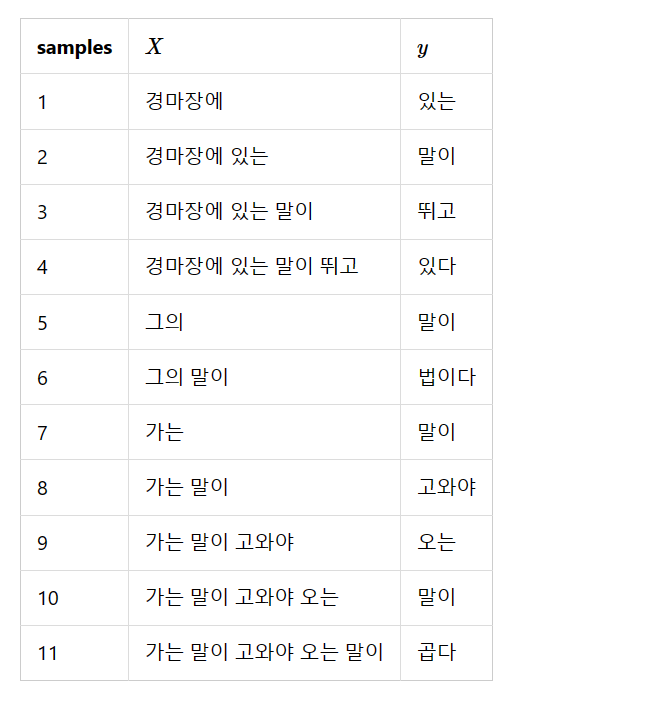

In [35]:
# 결과에 주석을 추가하였습니다. 왜 하나의 문장을 저렇게 나눌까요? 
# 예를 들어 '경마장에 있는 말이 뛰고 있다' 라는 문장 하나가 있을 때, 
# 최종적으로 원하는 훈련 데이터의 형태는 다음과 같습니다. 
# 하나의 단어를 예측하기 위해 이전에 등장한 단어들을 모두 참고

# 1~4번까지 

Image("image/08-06-01 Text Generation using RNN.png")

In [36]:
# 1~4번까지 
# 위의 sequences는 모든 문장을 각 단어가 각 시점(time step)마다 하나씩 추가적으로 등장하는 형태

# 아직 예측할 단어에 해당되는 레이블을 분리하는 작업까지는 수행하지 않은 상태
# 어떤 정수가 어떤 단어를 의미하는지 알아보기 위해 인덱스로부터 단어를 찾는 index_to_word를 만듭니다.

index_to_word = {}
for key, value in tokenizer.word_index.items(): # 인덱스를 단어로 바꾸기 위해 index_to_word를 생성
    index_to_word[value] = key

print('빈도수 상위 582번 단어 : {}'.format(index_to_word[582]))

빈도수 상위 582번 단어 : offer


In [37]:
# 582이라는 인덱스를 가진 단어는 본래 offer라는 단어였습니다. 원한다면 다른 숫자로도 시도

# 이제 데이터를 분리하기 전에 전체 샘플의 길이를 동일하게 만드는 패딩 작업을 수행합니다. 
# 패딩 작업을 수행하기 전에 가장 긴 샘플의 길이를 확인합니다.

max_len = max(len(l) for l in sequences)
print('샘플의 최대 길이 : {}'.format(max_len))

# 가장 긴 샘플의 길이인 24로 모든 샘플의 길이를 패딩하겠습니다.



샘플의 최대 길이 : 24


In [38]:
sequences = pad_sequences(sequences, maxlen=max_len, padding='pre')
print(sequences[:3])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0   99  269]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0   99  269  371]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0   99  269  371 1115]]


In [39]:
# padding='pre'를 설정하여 샘플의 길이가 24보다 짧은 경우에 앞에 0으로 패딩되었습니다. 
# 이제 맨 우측 단어만 레이블로 분리합니다.

sequences = np.array(sequences)
X = sequences[:,:-1]
y = sequences[:,-1]

In [40]:
print(X[:3])


[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0  99]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0  99 269]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0  99 269 371]]


In [41]:
# 훈련 데이터 X에서 3개의 샘플만 출력해보았는데, 
# 맨 우측에 있던 정수값 269, 371, 1115가 사라진 것을 볼 수 있습니다. 
# 뿐만 아니라, 각 샘플의 길이가 24에서 23으로 줄었습니다.

print(y[:3])


[ 269  371 1115]


In [ ]:
# 훈련 데이터 y 중 3개의 샘플만 출력해보았는데, 기존 훈련 데이터에서 맨 우측에 있던 정수들이 별도로 저장

y = to_categorical(y, num_classes=vocab_size)

# 레이블 데이터 y에 대해서 원-핫 인코딩을 수행하였습니다. 이제 모델을 설계합니다.

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM

In [48]:
embedding_dim = 10
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=200, verbose=2)

Epoch 1/200
244/244 - 5s - loss: 7.6396 - accuracy: 0.0293 - 5s/epoch - 19ms/step
Epoch 2/200
244/244 - 3s - loss: 7.1125 - accuracy: 0.0293 - 3s/epoch - 13ms/step
Epoch 3/200
244/244 - 3s - loss: 6.9809 - accuracy: 0.0336 - 3s/epoch - 14ms/step
Epoch 4/200
244/244 - 4s - loss: 6.8591 - accuracy: 0.0417 - 4s/epoch - 18ms/step
Epoch 5/200
244/244 - 4s - loss: 6.7074 - accuracy: 0.0458 - 4s/epoch - 18ms/step
Epoch 6/200
244/244 - 4s - loss: 6.5336 - accuracy: 0.0488 - 4s/epoch - 18ms/step
Epoch 7/200
244/244 - 5s - loss: 6.3360 - accuracy: 0.0534 - 5s/epoch - 19ms/step
Epoch 8/200
244/244 - 4s - loss: 6.1309 - accuracy: 0.0601 - 4s/epoch - 18ms/step
Epoch 9/200
244/244 - 4s - loss: 5.9331 - accuracy: 0.0619 - 4s/epoch - 18ms/step
Epoch 10/200
244/244 - 4s - loss: 5.7490 - accuracy: 0.0664 - 4s/epoch - 18ms/step
Epoch 11/200
244/244 - 4s - loss: 5.5750 - accuracy: 0.0715 - 4s/epoch - 17ms/step
Epoch 12/200
244/244 - 4s - loss: 5.4126 - accuracy: 0.0737 - 4s/epoch - 18ms/step
Epoch 13/200


Epoch 100/200
244/244 - 4s - loss: 0.6520 - accuracy: 0.8744 - 4s/epoch - 18ms/step
Epoch 101/200
244/244 - 4s - loss: 0.6393 - accuracy: 0.8759 - 4s/epoch - 18ms/step
Epoch 102/200
244/244 - 4s - loss: 0.6232 - accuracy: 0.8798 - 4s/epoch - 18ms/step
Epoch 103/200
244/244 - 4s - loss: 0.6104 - accuracy: 0.8802 - 4s/epoch - 18ms/step
Epoch 104/200
244/244 - 5s - loss: 0.6037 - accuracy: 0.8803 - 5s/epoch - 21ms/step
Epoch 105/200
244/244 - 5s - loss: 0.5871 - accuracy: 0.8835 - 5s/epoch - 20ms/step
Epoch 106/200
244/244 - 5s - loss: 0.5750 - accuracy: 0.8852 - 5s/epoch - 20ms/step
Epoch 107/200
244/244 - 5s - loss: 0.5603 - accuracy: 0.8880 - 5s/epoch - 20ms/step
Epoch 108/200
244/244 - 5s - loss: 0.5483 - accuracy: 0.8915 - 5s/epoch - 22ms/step
Epoch 109/200
244/244 - 5s - loss: 0.5368 - accuracy: 0.8941 - 5s/epoch - 19ms/step
Epoch 110/200
244/244 - 5s - loss: 0.5266 - accuracy: 0.8941 - 5s/epoch - 20ms/step
Epoch 111/200
244/244 - 5s - loss: 0.5169 - accuracy: 0.8967 - 5s/epoch - 20

Epoch 198/200
244/244 - 5s - loss: 0.2623 - accuracy: 0.9168 - 5s/epoch - 20ms/step
Epoch 199/200
244/244 - 5s - loss: 0.2624 - accuracy: 0.9167 - 5s/epoch - 21ms/step
Epoch 200/200
244/244 - 5s - loss: 0.2625 - accuracy: 0.9162 - 5s/epoch - 20ms/step


In [49]:
def sentence_generation(model, tokenizer, current_word, n): # 모델, 토크나이저, 현재 단어, 반복할 횟수
    init_word = current_word
    sentence = ''

    # n번 반복
    for _ in range(n):
        encoded = tokenizer.texts_to_sequences([current_word])[0]
        encoded = pad_sequences([encoded], maxlen=max_len-1, padding='pre')

        # 입력한 X(현재 단어)에 대해서 y를 예측하고 y(예측한 단어)를 result에 저장.
        result = model.predict(encoded, verbose=0)
        result = np.argmax(result, axis=1)

        for word, index in tokenizer.word_index.items(): 
            # 만약 예측한 단어와 인덱스와 동일한 단어가 있다면
            if index == result:
                break

        # 현재 단어 + ' ' + 예측 단어를 현재 단어로 변경
        current_word = current_word + ' '  + word

        # 예측 단어를 문장에 저장
        sentence = sentence + ' ' + word

    sentence = init_word + sentence
    return sentence

In [50]:
print(sentence_generation(model, tokenizer, 'i', 10))


i disapprove of school vouchers can i still apply for them


In [51]:
print(sentence_generation(model, tokenizer, 'how', 10))


how to make a crossword puzzle fire to be was over
